In [1]:
import cv2 as cv
import numpy as np

In [9]:
GENDER_MODEL='deploy_gender.prototxt'
GENDER_PROTO='gender_net.caffemodel'
MODEL_MEAN_VALUES=(78.4263377603,87.7689143744,114.895847746)
GENDER_LIST=['Male','Female']
FACE_PROTO="deploy.prototxt.txt"
FACE_MODEL="res10_300x300_ssd_iter_140000_fp16.caffemodel"

In [10]:
face_net=cv.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
gender_net=cv.dnn.readNetFromCaffe(GENDER_MODEL, GENDER_PROTO)

In [5]:
def get_faces(frame, confidence_threshold=0.5):
    blob = cv.dnn.blobFromImage(frame, 1.0, (300, 300), (104, 177.0, 123.0))
    face_net.setInput(blob)
    output = np.squeeze(face_net.forward())
    faces = []
    for i in range(output.shape[0]):
        confidence = output[i, 2]
        if confidence > confidence_threshold:
            box = output[i, 3:7] * \
                np.array([frame.shape[1], frame.shape[0],
                         frame.shape[1], frame.shape[0]])
            start_x, start_y, end_x, end_y = box.astype(np.int)
            start_x, start_y, end_x, end_y = start_x - \
                10, start_y - 10, end_x + 10, end_y + 10
            start_x = 0 if start_x < 0 else start_x
            start_y = 0 if start_y < 0 else start_y
            end_x = 0 if end_x < 0 else end_x
            end_y = 0 if end_y < 0 else end_y
            faces.append((start_x, start_y, end_x, end_y))
    return faces

In [12]:
def get_optimal_font_scale(text, width):
    """Determine the optimal font scale based on the hosting frame width"""
    for scale in reversed(range(0, 60, 1)):
        textSize = cv.getTextSize(text, fontFace=cv.FONT_HERSHEY_DUPLEX, fontScale=scale/10, thickness=1)
        new_width = textSize[0][0]
        if (new_width <= width):
            return scale/10
    return 1
def image_resize(image, width = None, height = None, inter = cv.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    return cv.resize(image, dim, interpolation = inter)

In [13]:
def display_img(title, img):
    """Displays an image on screen and maintains the output until the user presses a key"""
    cv.imshow(title, img)
    cv.waitKey(0)
    cv.destroyAllWindows()


In [2]:
def predict_gender(input_path: str):
    """Predict the gender of the faces showing in the image"""
    img = cv.imread(input_path)
    frame = img.copy()
    faces = get_faces(frame)
    for i, (start_x, start_y, end_x, end_y) in enumerate(faces):
        face_img = frame[start_y: end_y, start_x: end_x]
        blob = cv.dnn.blobFromImage(image=face_img, scalefactor=1.0, size=(227, 227), mean=MODEL_MEAN_VALUES, swapRB=False, crop=False)
        gender_net.setInput(blob)
        gender_preds = gender_net.forward()
        i = gender_preds[0].argmax()
        gender = GENDER_LIST[i]
        gender_confidence_score = gender_preds[0][i]
        label = "{}-{:.2f}%".format(gender, gender_confidence_score * 100)
        yPos = max(start_y - 15, 15)
        optimal_font_scale = get_optimal_font_scale(label, (end_x - start_x + 25))
        box_color = (255, 0, 0) if gender == "Male" else (147, 20, 255)
        cv.rectangle(frame, (start_x, start_y), (end_x, end_y), box_color, 2)
        cv.putText(frame, label, (start_x, yPos), cv.FONT_HERSHEY_SIMPLEX, optimal_font_scale, box_color, 2)
    cv2_imshow(frame)

In [3]:
from google.colab.patches import cv2_imshow

<ipython-input-5-fad2b429d8a1>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_x, start_y, end_x, end_y = box.astype(np.int)


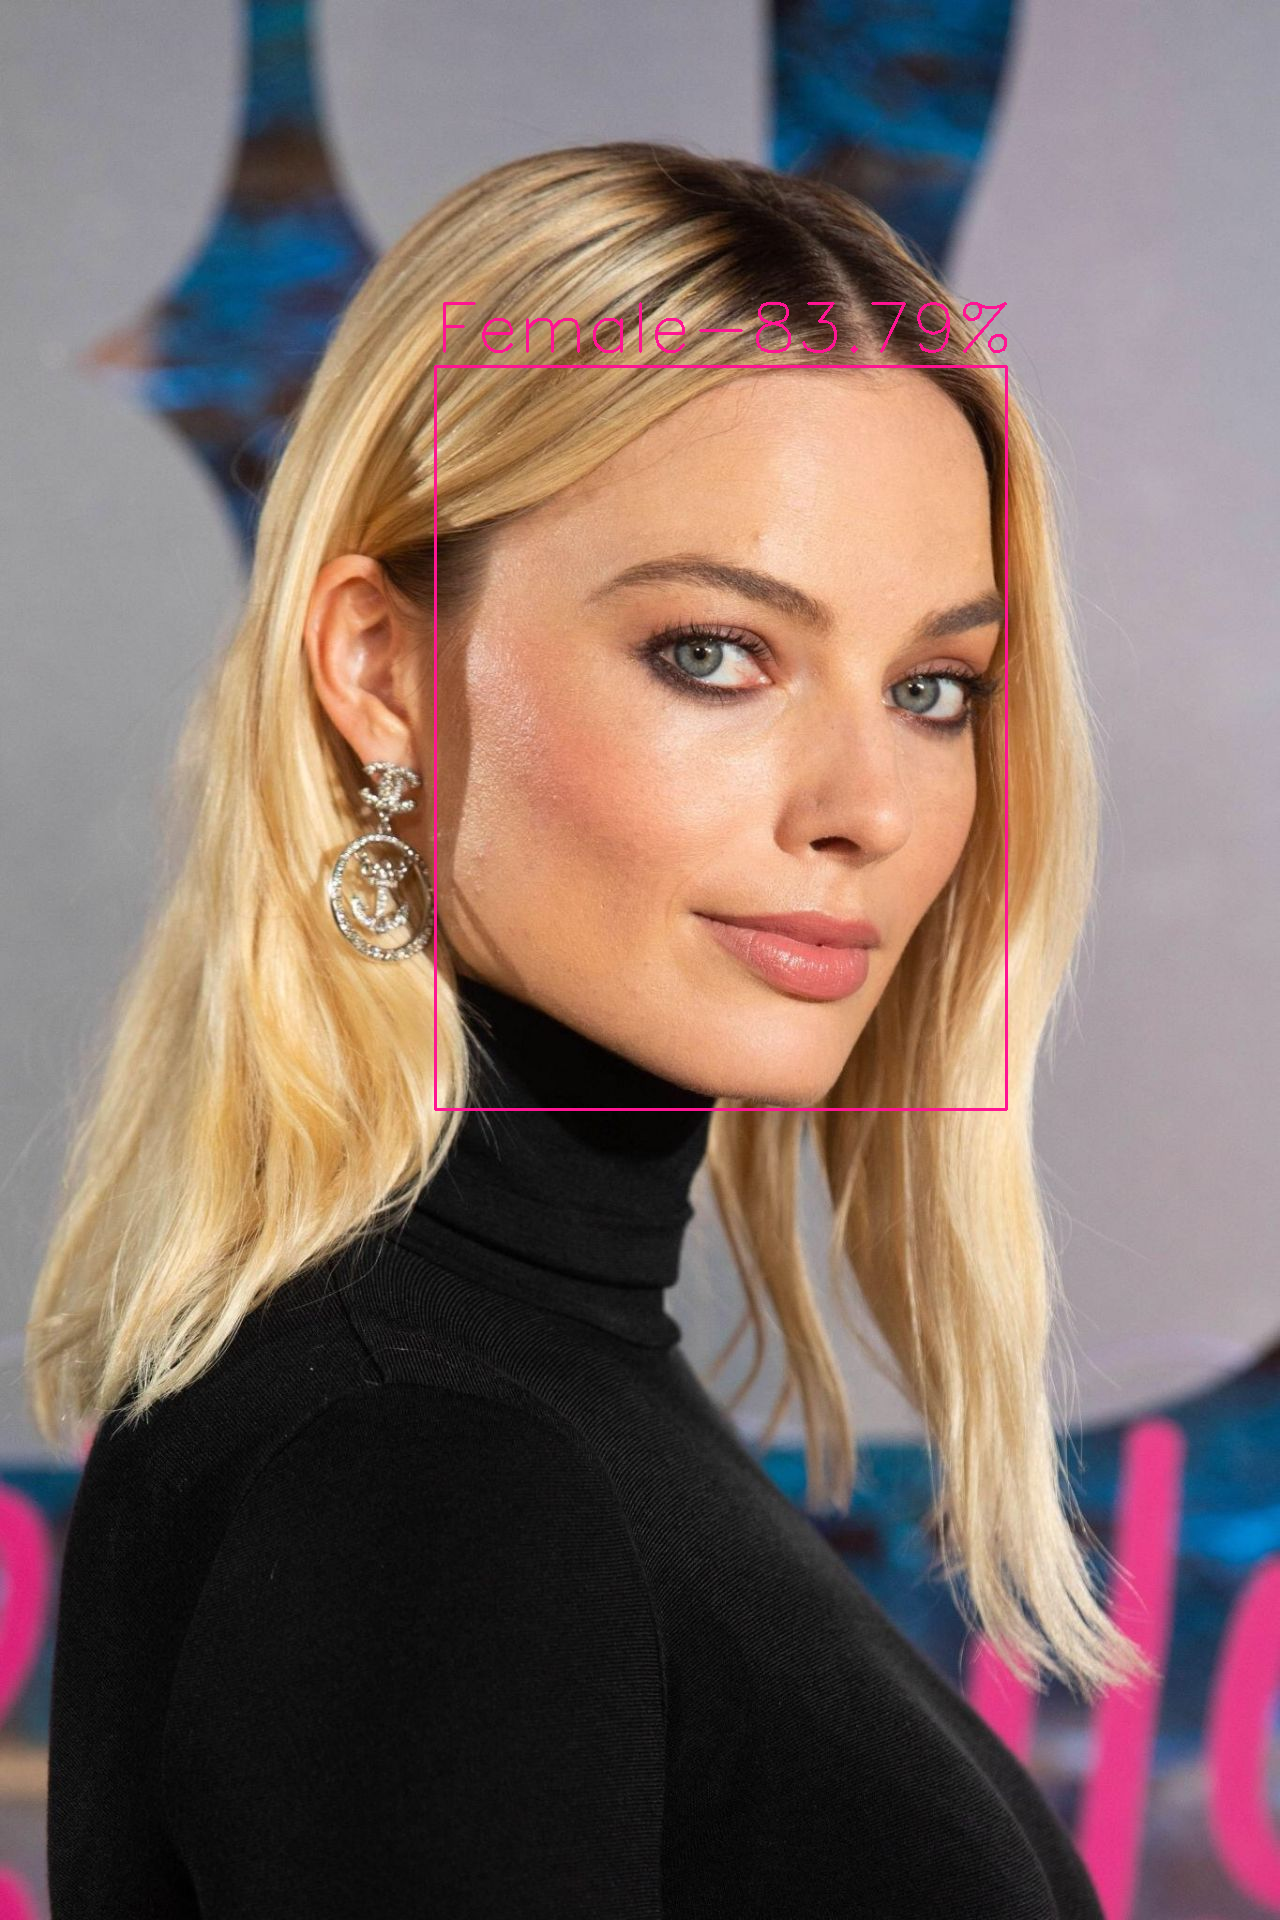

In [23]:
predict_gender('/content/margot_robie.jpg')